### Import Necessary Packages 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
import scipy.stats as sts

## Empirical Simulation:

In [9]:

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [10]:
class Customer:
    '''
    Store the properties of a customer including his/her start time in queue,
    total waiting (response) time and if s/he needs a manager support or not.
    '''
    def __init__(self):
        self.start_time = 0
        self.queue_time = 0 # total time in queue
        self.total_time = 0 # total waiting (response) time (queue+server+manager)
        # probability of his/her manager support need is equal to 
        # the prob of a random draw between 0 to 1 being less than 0.05
        self.manager_needed = sts.uniform.rvs() <= 0.05
        self.server_done = 0 # already served by cashier
        self.manager_done = 0 # already served by manager

class Manager:
    '''
    Implement the role of manager including a manager queue a method to 
    add customer in that queue
    '''
    def __init__(self, manager_distribution):
        self.queue = Queue(manager_distribution) # manager queue
        self.customers = [] # lists of customers that needed manager support 

    def add_customer(self, schedule, customer):
        self.customers.append(customer) # add the customer in the customers list of manager
        customer.manager_done = 1 # marked him/her served by manager
        self.queue.add_customer(schedule, customer, self) # add to manager queue


    

In [11]:
class Queue:
    '''
    Implement a M/G/1 queue for a given service distribution
    '''
    def __init__(self, service_distribution):
        self.service_distribution = service_distribution
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0
        self.customers = [] # all the customers in the queue

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so that we
        know which queue to choose when adding new customer. They will be
        added in queue with smallest queue_length+service_length
        '''
        return (self.people_in_queue+self.people_being_served) < (other.people_in_queue+other.people_being_served)

    def add_customer(self, schedule, customer, manager):
        # Add the customer to the queue
        self.people_in_queue += 1
        customer.start_time = schedule.now # customer start time in the queue
        self.customers.append(customer)
        # if there is no one being served
        # This customer can be served immediately
        if self.people_being_served < 1:
            schedule.add_event_after(0, self.start_serving_customer, manager)
            
    def start_serving_customer(self, schedule, manager):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # serve the first customer added in the list
        customer = self.customers.pop(0)
        queue_time = schedule.now - customer.start_time
        # adding queue time with its earlier queue time
        # (for a customer who needs manager support, will stand in both service queue, then manager queue)
        customer.queue_time += queue_time 
        
        # Schedule when the server will be done with the customer.
        # Generate a random service time from the service distribution.
        service_time = self.service_distribution.rvs()
        customer.total_time += (queue_time + service_time)
        
        customer.server_done == 1 
        # send the customer to manager queue, if s/he needs manager support 
        # and still not served by manager
        if (customer.manager_needed and customer.manager_done == 0):
            manager.add_customer(schedule, customer)

        schedule.add_event_after(
            service_time,
            self.finish_serving_customer, manager)
            
    def finish_serving_customer(self, schedule, manager):
        # Remove the customer from the server
        self.people_being_served -= 1

        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer, manager)


class GroceryStore:
    '''
    Implement the simulation of a grocery store with given number od cashier and 
    given arrival time, service time and manager-service time distribution
    '''
    def __init__(self, arrival_distribution, service_distribution, manager_distribution, n_cashier):
        # one service queue per each of the cashier
        self.queue = np.array([Queue(service_distribution) for _ in range(n_cashier)])
        self.max_queue_length = 0 
        self.arrival_distribution = arrival_distribution
        # creating a manager object with given distribution
        self.manager = Manager(manager_distribution)
        self.customers = [] # all the customers who visit the store
        self.extra_time = 0 # extra time the store is open after 6PM
        self.total_open_hour = 540 # 9AM to 6PM (9 hour = 540 minutes)

    def add_customer(self, schedule):
        customer = Customer() # customer object
        self.customers.append(customer) # add in the customer list
        # Add this customer to the queue with smallest length
        smallest_queue = np.argmin(self.queue)
        self.queue[smallest_queue].add_customer(schedule, customer, self.manager)

        # Update the maximum queue length by comparing with the length of this queue  
        self.max_queue_length = max(self.max_queue_length, 
                                    self.queue[smallest_queue].people_in_queue)
        # Schedule when to add another customer
        next_arrival = self.arrival_distribution.rvs()
        # continue adding new customer until the next arrival time passes 6 PM
        if schedule.now + next_arrival < self.total_open_hour:
            schedule.add_event_after(next_arrival, 
                                     self.add_customer)
        
    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_distribution, service_distribution, manager_distribution, n_cashier):
    schedule = Schedule() # priority schedule
    grocery_store = GroceryStore(arrival_distribution, service_distribution, manager_distribution, n_cashier)
    grocery_store.run(schedule)
    # run the simulation until there is no customer left in the store
    while len(schedule.priority_queue) > 0: 
        schedule.run_next_event()
    # calculating extra time 
    grocery_store.extra_time = schedule.now - grocery_store.total_open_hour
    return grocery_store

In [12]:
# arrival distribution
arrival_rate = 1
arrival_distribution = sts.expon(scale=1/arrival_rate)

# service time distribution (truncated normal as it has to be positive)
lower, upper = 0, np.inf
mu_server, sigma = 3, 1
service_distribution = sts.truncnorm((lower - mu_server) / sigma, 
                    (upper - mu_server) / sigma, loc=mu_server, scale=sigma)

# manager distribution
mu_manager, sigma = 4, 1
manager_distribution = sts.truncnorm((lower - mu_manager) / sigma, 
                    (upper - mu_manager) / sigma, loc=mu_manager, scale=sigma)


n_cashier = 4

# Run the simulation once

grocery_store = run_simulation(arrival_distribution, service_distribution, manager_distribution, n_cashier)
print(f'People in the queue: {[queue.people_in_queue for queue in grocery_store.queue]}')
print(f'There were maximum {grocery_store.max_queue_length} people in the queue')
print(f'Ending time {grocery_store.extra_time + grocery_store.total_open_hour:5.2f}',
      f'extra time: {grocery_store.extra_time:5.2f}')

People in the queue: [0, 0, 0, 0]
There were maximum 3 people in the queue
Ending time 546.24 extra time:  6.24


## Expected value of the metric parameters

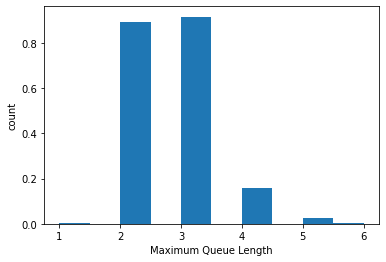

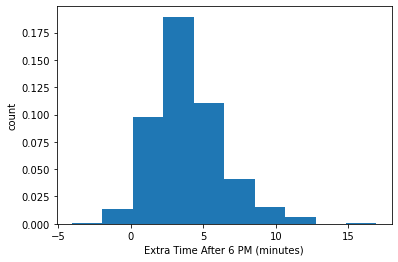

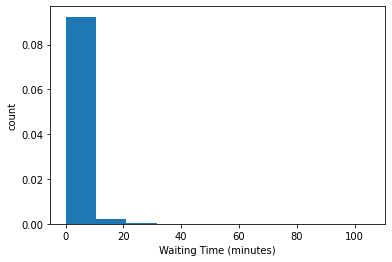

In [ ]:
iteration = 1000
n_cashier = 4

# list for storing the values from each simulation
waiting_times = []
max_queue_lengths = []
extra_times = []

for i in range(iteration):
    grocery_store = run_simulation(arrival_distribution, service_distribution, 
                                   manager_distribution, n_cashier = n_cashier)
    max_queue_lengths.append(grocery_store.max_queue_length)
    extra_times.append(grocery_store.extra_time)
    waiting_times += [customer.total_time for customer in grocery_store.customers]

plt.hist(max_queue_lengths, density = True)
plt.xlabel('Maximum Queue Length')
plt.ylabel('count')
plt.show()

plt.hist(extra_times, density = True)
plt.xlabel('Extra Time After 6 PM (minutes)')
plt.ylabel('count')
plt.show()

plt.hist(waiting_times, density = True)
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('count')
plt.show()

In [ ]:
def confidence_interval(data):
    # calculate confidence interval using the formula
    n = len(data)
    m = np.mean(data) # sample mean
    s = np.std(data, ddof = 1) # sample SD
    t = s / np.sqrt(n) # standard error

    return np.array([m - 1.96*t, m + 1.96*t])

print('expected maximum queue length:', np.mean(max_queue_lengths).round(3))
print('95% confidence interval of maximum queue length mean:', confidence_interval(max_queue_lengths).round(3))

expected maximum queue length: 2.66
95% confidence interval of maximum queue length mean: [2.617 2.703]


In [ ]:
print('expected avg waiting time:', np.mean(waiting_times).round(3))
print('95% confidence interval of avg waiting time:', confidence_interval(waiting_times).round(3))

expected avg waiting time: 4.346
95% confidence interval of avg waiting time: [4.338 4.354]


In [ ]:
print('expected extra time:', np.mean(extra_times).round(3))
print('95% confidence interval of avg extra time:', confidence_interval(extra_times).round(3))

expected extra time: 3.896
95% confidence interval of avg extra time: [3.749 4.043]


## Expected value for the parameters for a given number of cashier

In [ ]:
# n_cashier goes from 1 to 10
n_cashier = np.array(range(1,11))

waiting_time_means = []
waiting_time_conf_intervals = []
max_queue_length_means = []
max_queue_length_conf_intervals = []
extra_time_means = []
extra_time_conf_intervals = []

for i in n_cashier:
    iteration = 1000
    waiting_times = []
    max_queue_lengths = []
    extra_times = []

    for j in range(iteration):
        grocery_store = run_simulation(arrival_distribution, service_distribution, 
                                       manager_distribution, n_cashier = i)
        max_queue_lengths.append(grocery_store.max_queue_length)
        extra_times.append(grocery_store.extra_time)
        waiting_times += [customer.total_time for customer in grocery_store.customers]

    max_queue_length_means.append(np.mean(max_queue_lengths))
    max_queue_length_conf_intervals.append(confidence_interval(max_queue_lengths))

    waiting_time_means.append(np.mean(waiting_times))
    waiting_time_conf_intervals.append(confidence_interval(waiting_times))

    extra_time_means.append(np.mean(extra_times))
    extra_time_conf_intervals.append(confidence_interval(extra_times))



In [ ]:
# calculating the error bar length in each side by subtracting 
# the lower bound of CI from the mean

waiting_time_means = np.array(waiting_time_means)
waiting_time_conf_intervals = np.array(waiting_time_conf_intervals)
waiting_time_y_error = waiting_time_means - waiting_time_conf_intervals[:,0]

max_queue_length_means = np.array(max_queue_length_means)
max_queue_length_conf_intervals = np.array(max_queue_length_conf_intervals)
max_queue_length_y_error = max_queue_length_means - max_queue_length_conf_intervals[:,0]

extra_time_means = np.array(extra_time_means)
extra_time_conf_intervals = np.array(extra_time_conf_intervals)
extra_time_y_error = extra_time_means - extra_time_conf_intervals[:,0]


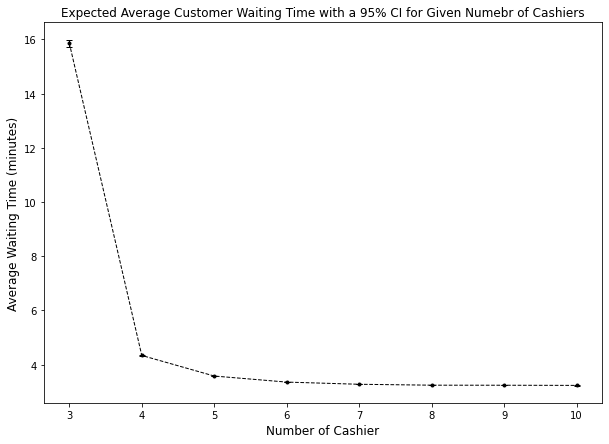

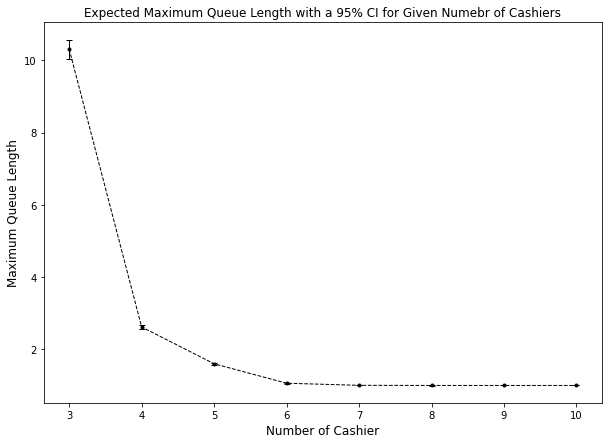

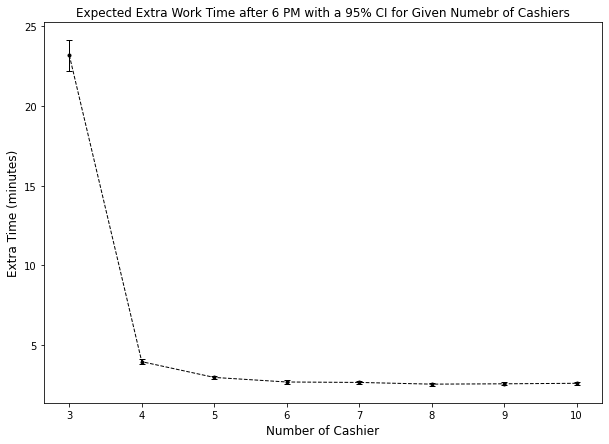

In [ ]:
# plotting the result for n_cashier = 3 or more to see it better

plt.figure(figsize=(10,7))
plt.errorbar(n_cashier[2:], waiting_time_means[2:], waiting_time_y_error[2:], 
             color='black', marker='.', capsize = 3, linestyle='--', linewidth=1)
plt.title('Expected Average Customer Waiting Time with a 95% CI for Given Numebr of Cashiers')
plt.xlabel('Number of Cashier', fontsize=12)
plt.ylabel('Average Waiting Time (minutes)', fontsize=12)
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(n_cashier[2:], max_queue_length_means[2:], max_queue_length_y_error[2:], 
             color='black', marker='.', capsize = 3, linestyle='--', linewidth=1)
plt.title('Expected Maximum Queue Length with a 95% CI for Given Numebr of Cashiers')
plt.xlabel('Number of Cashier', fontsize=12)
plt.ylabel('Maximum Queue Length', fontsize=12)
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(n_cashier[2:], extra_time_means[2:], extra_time_y_error[2:], color='black', 
             marker='.', capsize = 3, linestyle='--', linewidth=1)
plt.title('Expected Extra Work Time after 6 PM with a 95% CI for Given Numebr of Cashiers')
plt.xlabel('Number of Cashier', fontsize=12)
plt.ylabel('Extra Time (minutes)', fontsize=12)
plt.show()

## Theoritical Analysis

In [ ]:
def avg_time_in_queue(n_cashier):
    waiting_in_queue = (3.2**2/n_cashier)/(2*(1-3.2/n_cashier)) * (1+1/3.2**2)
    return waiting_in_queue

def avg_response_time(n_cashier):
    waiting_in_queue = avg_time_in_queue(n_cashier)
    response_time = 3 + waiting_in_queue
    return response_time  

def avg_queue_length(n_cashier):
    waiting_in_queue = avg_time_in_queue(n_cashier)
    queue_length = (1/n_cashier) * waiting_in_queue
    return queue_length

def total_customer_in_system(n_cashier):
    response_time = avg_response_time(n_cashier)
    total_customer = (1/n_cashier) * response_time
    return total_customer

In [ ]:
avg_response_time(4)

10.025000000000002

## Comparison between Theoritical and Empirical Result

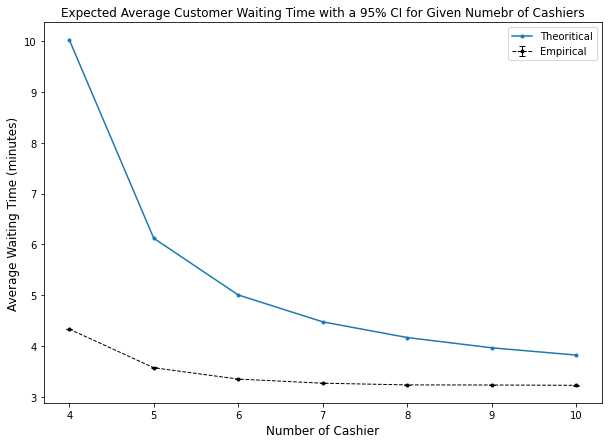

In [ ]:
n_cashier = range(4,11)
theoritical_waiting_time_means = [avg_response_time(i) for i in n_cashier]

plt.figure(figsize=(10,7))
plt.errorbar(n_cashier, waiting_time_means[3:], waiting_time_y_error[3:], 
             color='black', marker='.', capsize = 3, linestyle='--', 
             linewidth=1, label = 'Empirical')
plt.plot(n_cashier, theoritical_waiting_time_means, label = 'Theoritical',
         marker='.')
plt.title('Expected Average Customer Waiting Time with a 95% CI for Given Numebr of Cashiers')
plt.xlabel('Number of Cashier', fontsize=12)
plt.ylabel('Average Waiting Time (minutes)', fontsize=12)
plt.legend()
plt.show()

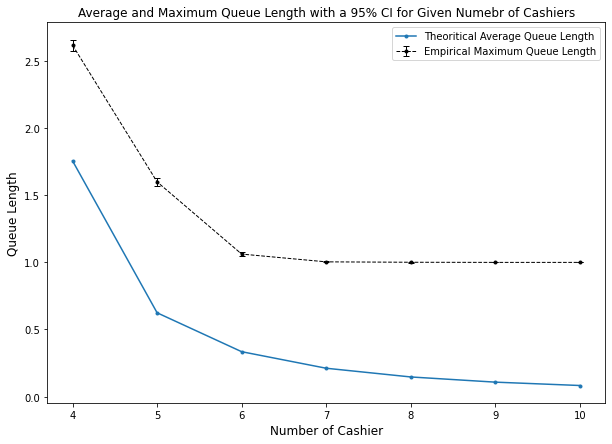

In [ ]:
n_cashier = range(4,11)
theoritical_queue_length_means = [avg_queue_length(i) for i in n_cashier]

plt.figure(figsize=(10,7))
plt.errorbar(n_cashier, max_queue_length_means[3:], max_queue_length_y_error[3:], 
             color='black', marker='.', capsize = 3, linestyle='--', 
             label = 'Empirical Maximum Queue Length', linewidth=1)
plt.plot(n_cashier, theoritical_queue_length_means, 
         label = 'Theoritical Average Queue Length', marker='.')
plt.title('Average and Maximum Queue Length with a 95% CI for Given Numebr of Cashiers')
plt.xlabel('Number of Cashier', fontsize=12)
plt.ylabel('Queue Length', fontsize=12)
plt.legend()
plt.show()

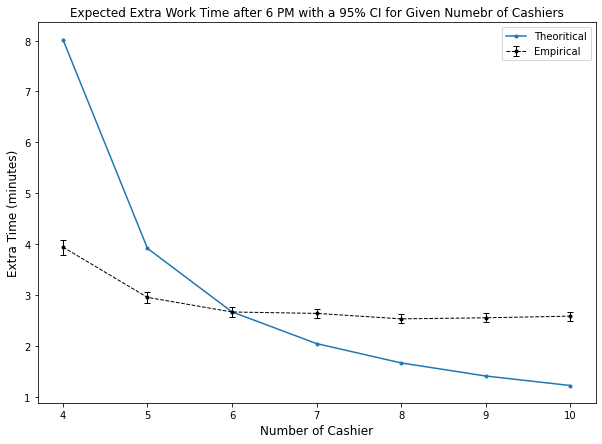

In [ ]:
n_cashier = range(4,11)
theoritical_extra_time_means = [total_customer_in_system(i)*3.2 for i in n_cashier]

plt.figure(figsize=(10,7))
plt.errorbar(n_cashier, extra_time_means[3:], extra_time_y_error[3:], color='black', 
             marker='.', capsize = 3, linestyle='--', linewidth=1, label = 'Empirical')
plt.plot(n_cashier, theoritical_extra_time_means, 
         label = 'Theoritical', marker='.')
plt.title('Expected Extra Work Time after 6 PM with a 95% CI for Given Numebr of Cashiers')
plt.xlabel('Number of Cashier', fontsize=12)
plt.ylabel('Extra Time (minutes)', fontsize=12)
plt.legend()
plt.show()